## Writing Assistant - NoteWise

### Description
NoteWise is a writing assistant, with the following functionalities

`Topic Selection`
* The use enter the topic they want to write about

`Template`
* The user can select the template they want to use for their writing

`subtopic Generation`
* The Agent generates subtopics based on the topics, reserach (websearch)
* The user can select the subtopics they want to write about 

`Research Tools`
* Research tools include wikipedia, web search and user input(content from the user)
* The user can select the research tool they want to use for their writing

`Document Writing`
* The Agent generates the writing based on the research tools and the user input
* The user can confirm the writing or correct it 


In [2]:
# Imports
import os 
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

load_dotenv()

True

In [3]:
OPENAI_KEY = os.getenv("OPENAI_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [4]:
llm = ChatOpenAI(model = "gpt-4o", temperature = 0)

In [7]:
## define states
class SubTopic(BaseModel):
    title: str = Field(
        description= "title for the subtopic"
    )
    content: str = Field(
        description="topic for the subtopic"
    )

class SubTopicList(BaseModel):
    subTopics: List[SubTopic] = Field(
        description= "a comprehensive list of subtopics"
    )
    
class GenerateWritingState(TypedDict):
    topic: str
    writing_type:str
    subtopics: List[SubTopic]
    max_subtopics: int
    human_feedback: str
    template: str
    tools: List[str]
    writing: str

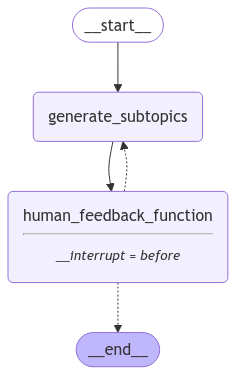

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

generate_subtopics_prompt = """
You are tasked with creating subtopics for a {writing_type}, follow these instructions carefully:
1. Carefully analyse this topic to understand what it is and what is required of it:
{topic}
2. Examine any editorial feedback that has been optionally provided to guide in the creation of subtopics
{human_feedback}
3. Dertemine the most interesting sub topics and pick the top {max_subtopics}
4. In the content part put an empty string for now
"""
def generate_subtopics(state: GenerateWritingState):
    
    writing_type = state["writing_type"]
    topic = state["topic"]
    human_feedback = state.get("human_feedback", None)
    max_subtopics = state["max_subtopics"]
    
    formatted_prompt = generate_subtopics_prompt.format(writing_type = writing_type, topic = topic, human_feedback = human_feedback, max_subtopics = max_subtopics)
    
    structured_llm = llm.with_structured_output(SubTopicList)
    
    subtopics = structured_llm.invoke([SystemMessage(content=formatted_prompt)] + [HumanMessage(content="generate subtopics")])
    
    return {"subtopics" : subtopics.subTopics}

def human_feedback_function(state: GenerateWritingState):
    pass

def subtopics_confirmation(state: GenerateWritingState):
    human_feedback = state.get("human_feedback", None)
    
    if human_feedback:
        print("am deciding loop", human_feedback)
        return "generate_subtopics"
    print("am deciding to end", human_feedback)
    return END

# create a graph builder
builder = StateGraph(GenerateWritingState)

# Add a node
builder.add_node(generate_subtopics, "generate_subtopics")
builder.add_node(human_feedback_function, "human_feedback_function")

# add edges
builder.add_edge(START, "generate_subtopics")
builder.add_edge("generate_subtopics", "human_feedback_function")
builder.add_conditional_edges("human_feedback_function", subtopics_confirmation, ["generate_subtopics", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_function'],checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))



In [69]:
topic = "what is Artificial intelligence"
writing_type = "Blog"
max_subtopics = 5
template = """
Title: [Enter the blog title here]

Introduction:
[Write an engaging introduction that explains what the blog will cover and why it's important.]

Table of Contents:
1. [What is Topic?]
2. [Why is Topic Important?]
3. [Key Insights]
4. [How to Implement Topic]
5. [Challenges and Solutions]
6. [Conclusion]

Body:
1. What is Topic?
   [Explain the topic clearly with examples or analogies.]

2. Why is Topic Important?
   [Discuss the significance of the topic with supporting data or real-world examples.]

3. Key Insights:
   - [Key Insight 1]
   - [Key Insight 2]
   - [Key Insight 3]

4. How to Implement Topic:
   - Step 1: [Explain step 1]
   - Step 2: [Explain step 2]
   - Step 3: [Explain step 3]

5. Challenges and Solutions:
   - Challenge 1: [Describe challenge]
     - Solution: [Provide solution]
   - Challenge 2: [Describe challenge]
     - Solution: [Provide solution]

Conclusion:
[Summarize the blog's key points and end with a call-to-action or final thoughts.]

References/Further Reading:
- [Reference 1]
- [Reference 2]
"""

thread = {"configurable": {"thread_id": "1"}}
graph.invoke({"topic":topic, "writing_type": writing_type, "max_subtopics": max_subtopics, "template": template }, thread)


{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Introduction to Artificial Intelligence', content=''),
  SubTopic(title='History and Evolution of AI', content=''),
  SubTopic(title='Types of Artificial Intelligence', content=''),
  SubTopic(title='Applications of AI in Various Industries', content=''),
  SubTopic(title='Ethical Considerations in AI Development', content='')],
 'max_subtopics': 5,
 'template': "\nTitle: [Enter the blog title here]\n\nIntroduction:\n[Write an engaging introduction that explains what the blog will cover and why it's important.]\n\nTable of Contents:\n1. [What is Topic?]\n2. [Why is Topic Important?]\n3. [Key Insights]\n4. [How to Implement Topic]\n5. [Challenges and Solutions]\n6. [Conclusion]\n\nBody:\n1. What is Topic?\n   [Explain the topic clearly with examples or analogies.]\n\n2. Why is Topic Important?\n   [Discuss the significance of the topic with supporting data or real-world examples.]\n\n3. 

In [70]:
state = graph.get_state(thread)
state.values

{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Introduction to Artificial Intelligence', content=''),
  SubTopic(title='History and Evolution of AI', content=''),
  SubTopic(title='Types of Artificial Intelligence', content=''),
  SubTopic(title='Applications of AI in Various Industries', content=''),
  SubTopic(title='Ethical Considerations in AI Development', content='')],
 'max_subtopics': 5,
 'template': "\nTitle: [Enter the blog title here]\n\nIntroduction:\n[Write an engaging introduction that explains what the blog will cover and why it's important.]\n\nTable of Contents:\n1. [What is Topic?]\n2. [Why is Topic Important?]\n3. [Key Insights]\n4. [How to Implement Topic]\n5. [Challenges and Solutions]\n6. [Conclusion]\n\nBody:\n1. What is Topic?\n   [Explain the topic clearly with examples or analogies.]\n\n2. Why is Topic Important?\n   [Discuss the significance of the topic with supporting data or real-world examples.]\n\n3. 

In [71]:
graph.update_state(thread, {"human_feedback":"the subtopics are not related to the suplied topic"})
# graph.get_state(thread).values

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa66ec-3c4f-6a51-8002-9c1b31855186'}}

In [72]:
state = graph.get_state(thread)
state.next

('human_feedback_function',)

In [73]:
graph.invoke(None,thread)

am deciding to end None


{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Introduction to Artificial Intelligence', content=''),
  SubTopic(title='History and Evolution of AI', content=''),
  SubTopic(title='Types of Artificial Intelligence', content=''),
  SubTopic(title='Applications of AI in Various Industries', content=''),
  SubTopic(title='Ethical Considerations in AI Development', content='')],
 'max_subtopics': 5,
 'human_feedback': 'the subtopics are not related to the suplied topic',
 'template': "\nTitle: [Enter the blog title here]\n\nIntroduction:\n[Write an engaging introduction that explains what the blog will cover and why it's important.]\n\nTable of Contents:\n1. [What is Topic?]\n2. [Why is Topic Important?]\n3. [Key Insights]\n4. [How to Implement Topic]\n5. [Challenges and Solutions]\n6. [Conclusion]\n\nBody:\n1. What is Topic?\n   [Explain the topic clearly with examples or analogies.]\n\n2. Why is Topic Important?\n   [Discuss the signi

In [38]:
graph.update_state(thread,{"human_feedback":None}, as_node="human_feedback_function")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa66c2-9aea-6ee2-8009-44f965bcb1d5'}}

In [39]:
graph.invoke(None, thread)

{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Introduction to the Basics of the Topic', content=''),
  SubTopic(title='Historical Background and Evolution', content=''),
  SubTopic(title='Key Concepts and Terminologies', content=''),
  SubTopic(title='Current Trends and Developments', content=''),
  SubTopic(title='Challenges and Controversies', content=''),
  SubTopic(title='Future Prospects and Innovations', content='')],
 'max_subtopics': 5,
 'template': "\nTitle: [Enter the blog title here]\n\nIntroduction:\n[Write an engaging introduction that explains what the blog will cover and why it's important.]\n\nTable of Contents:\n1. [What is Topic?]\n2. [Why is Topic Important?]\n3. [Key Insights]\n4. [How to Implement Topic]\n5. [Challenges and Solutions]\n6. [Conclusion]\n\nBody:\n1. What is Topic?\n   [Explain the topic clearly with examples or analogies.]\n\n2. Why is Topic Important?\n   [Discuss the significance of the topic w

In [40]:
state = graph.get_state(thread)
state.next

('human_feedback_function',)